In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<font color = "Red">
<h3>Here we will be building a logistic regression classifier to recognize cats</h3>
<font color = "Black">
<h4>Following code will give intuition about the deep learning<h4>
<h5>We will build a general architecture of a learning algorithm, we will write our own functions that is required for us inorder to build a model.<\h5>

# Table of contents
- [1- Load Dataset](#1)
- [2-Preprocess the data](#2)
- [3-Define all the functions that are needed](#3)
- [4-Merge all the functions in the model](#4)

In [6]:
import numpy as np
import h5py

<a name ='1'></a>
# 1- Load Dataset #


*  h5py is a common package to interact with the dataset that is stored on an H5 file.
*  here we are converting the dataset into an array

In [7]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [8]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [9]:
import matplotlib.pyplot as plt

y = [0], it's a 'non-cat' picture.


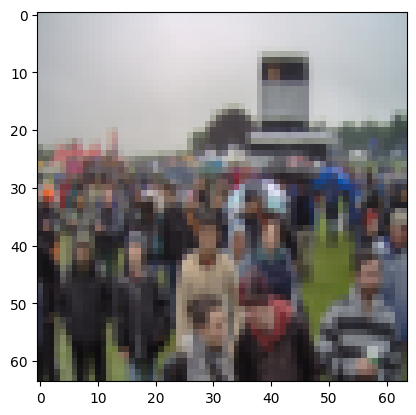

In [10]:
# Example of a picture
index = 100
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" +
       classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

<a name = "2"></a>
# 2- Preprocess the data #


Each image is of shape (num_px, num_px, 3) where 3 is for the 3 channel(RGB). Thus, each image is square(height =num_px) and (width = num_px)
<br>
The main aim in preprocessing is :
    
   2.1 Capture the # of train examples, height , # of channel.
   <br>
   2.2 Convert each image into vector : image shape =(num_px, num_px, 3) =>  vector shape = (num_px* num_px * 3, 1)
   <br>
   2.2.1 After this the dataset is a numpy-array where each column represents a flattened image. There should be m_train(respectively m_test) columns.
   <br>
    2.3 Standardize the dataset.


* Here `m_train` is the number of training example. Similarly `m_test` is the number of test examples.
* `nu,_px` gives you the height or weight of a training.
* `train_set_x_orig` is numpy array of shape (m_train, num_px, num_px, 3)

## 2.1 Capture the # of train examples, height , # of channel.

In [11]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


## 2.2 Convert each image into vector :

In [12]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T


print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


## 2.3 Standardize the dataset.

In [13]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

<a name = '3'></a>
# 3- Define all the functions that are needed #

Here we will be building the a logistic regression using the neural network mindset.
<br>
Mathematical Expression of the algorithm:
<br>
For 1 training example $x^{(i)}$ :
$$z^{(i)} = w^T{x}^{(i)} + b $$
$$\hat y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$
The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$



- We need sigmoid function as activation function
- We need to intialize the parameters of the model i.e. w and b.
- Learn the parameters by minimizing the cost.
- Use the learned parameters to predict.

In [14]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [15]:
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0.0
    return w,b

In [16]:
def propagate(w,b,X,Y):
    m = X.shape[1]


    A = sigmoid(np.dot(w.T,X)+ b)
    cost = -1./m* np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))


    dw = 1./m*np.dot(X, (A-Y).T)
    db = 1./m*np.sum(A-Y)


    cost = np.squeeze(np.array(cost))


    grads = {"dw": dw,
             "db": db}

    return grads, cost


In [17]:
import copy

In [18]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)

    costs = []

    for i in range(num_iterations):
        grads, cost =propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}


    #print ("w = " + str(params["w"]))
    #print ("b = " + str(params["b"]))
    #print ("dw = " + str(grads["dw"]))
    #print ("db = " + str(grads["db"]))
    #print("Costs = " + str(costs))

    return params, grads, costs


In [19]:
def predict(w, b, X):

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    A =   sigmoid(np.dot(w.T, X) + b)

    for i in range(A.shape[1]):

        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
             Y_prediction[0, i] = 0



    return Y_prediction

<a name = "4"></a>
# 4- Merge all the functions in the model

In [20]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):

    w, b = initialize_with_zeros(X_train.shape[0])
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = print_cost)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)



    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [21]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x,
                                  test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 0, you predicted that it is a "non-cat" picture.


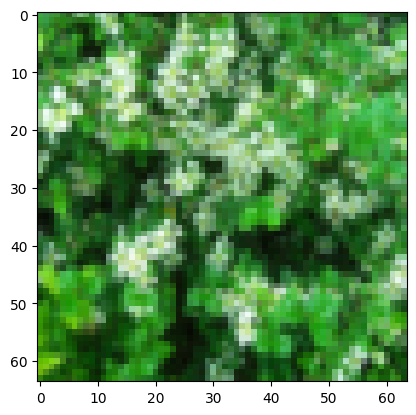

In [22]:
# Example of a picture that was wrongly classified.
index = 22
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" +
       classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

In [23]:
# Plot learning curve (with costs)
# costs = np.squeeze(logistic_regression_model['costs'])
# plt.plot(costs)
# plt.ylabel('cost')
# plt.xlabel('iterations (per hundreds)')
# plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
# plt.show()

In [24]:
# learning_rates = [0.01, 0.001, 0.0001]
# models = {}

# for lr in learning_rates:
#     print ("Training a model with learning rate: " + str(lr))
#     models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
#     print ('\n' + "-------------------------------------------------------" + '\n')

# for lr in learning_rates:
#     plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

# plt.ylabel('cost')
# plt.xlabel('iterations (hundreds)')

# legend = plt.legend(loc='upper center', shadow=True)
# frame = legend.get_frame()
# frame.set_facecolor('0.90')
# plt.show()

y = 1.0, your algorithm predicts a "cat" picture.


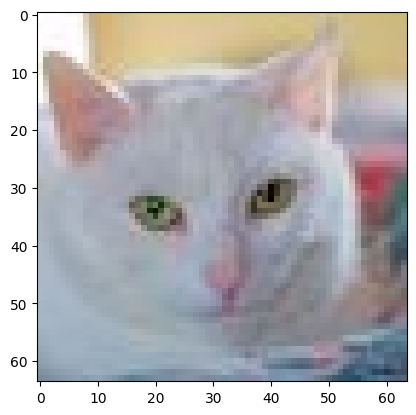

In [26]:
from PIL import Image
# change this to the name of your image file
my_image = "my_image4.jpg" # change this to the name of your image file
# We preprocess the image to fit your algorithm.
fname = "/content/" + my_image
import matplotlib
matplotlib.pyplot
# image = np.array(ndimage.imread(fname, flatten=False))
image = np.array(matplotlib.pyplot.imread(fname))
image = image/255.
# original
# my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
# stackoverflow
# from PIL import Image
# my_image = Image.fromarray(image).resize(size=(num_px, num_px))
# without resize
my_image = image.reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], my_image)
plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")